# Proyecto: Clasificación de Pacientes mediante Análisis de Ritmo Cardíaco

## Objetivo

Desarrollar habilidades en el procesamiento y análisis de señales biomédicas, específicamente electrocardiogramas (ECG), para clasificar a los pacientes en diferentes categorías basadas en sus ritmos cardíacos. Utilizarán una base de datos que contiene registros de pacientes con ritmos cardíacos normales (Sinus) y con fibrilación auricular (AF).

## Requisitos

1. El clasificador desarrollado debe estar basado en uno de los modelos vistos en clase durante el tema de análisis de ritmos cardíacos. Esto les permitirá aplicar los conocimientos teóricos adquiridos y adaptarlos a un contexto práctico.
2. No es necesario realizar el procedimiento de detección de latidos desde la señal ECG. En vez de eso, utilicen las anotaciones propias tal y como se vio en la práctica.

## Base de Datos

La base de datos proviene del conjunto de datos MIT-BIH, que incluye registros de ECG de pacientes con diferentes condiciones cardíacas. Tendrán acceso a registros de 10 pacientes con ritmos cardíacos normales y 10 pacientes con fibrilación auricular. Cada registro contiene señales de ECG y las correspondientes anotaciones que indican los eventos cardíacos.

In [62]:
Lista_sinusal = [
    "16265",
    "16272",
    "16273",
    "16420",
    "16483",
    "16539",
    "16773",
    "16786",
    "16795",
    "17052",
]
pn_dir_sinusal = "nsrdb"
Lista_fibrilacion = [
    "04015",
    "04043",
    "04048",
    "04126",
    "04746",
    "04908",
    "04936",
    "05091",
    "05121",
    "05261",
]
pn_dir_fibrilacion = "afdb"

## Construcción de entorno
**Importamos paquetes** necesarios para poder procesar los datos.

In [63]:
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fftpack import fft, fftfreq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import plotly.graph_objects as go
from scipy.stats import entropy
import wfdb.processing as wp

## Metodología

1. **Preprocesamiento de Datos**: Cargar y limpiar los datos de ECG, eliminando ruido y artefactos.

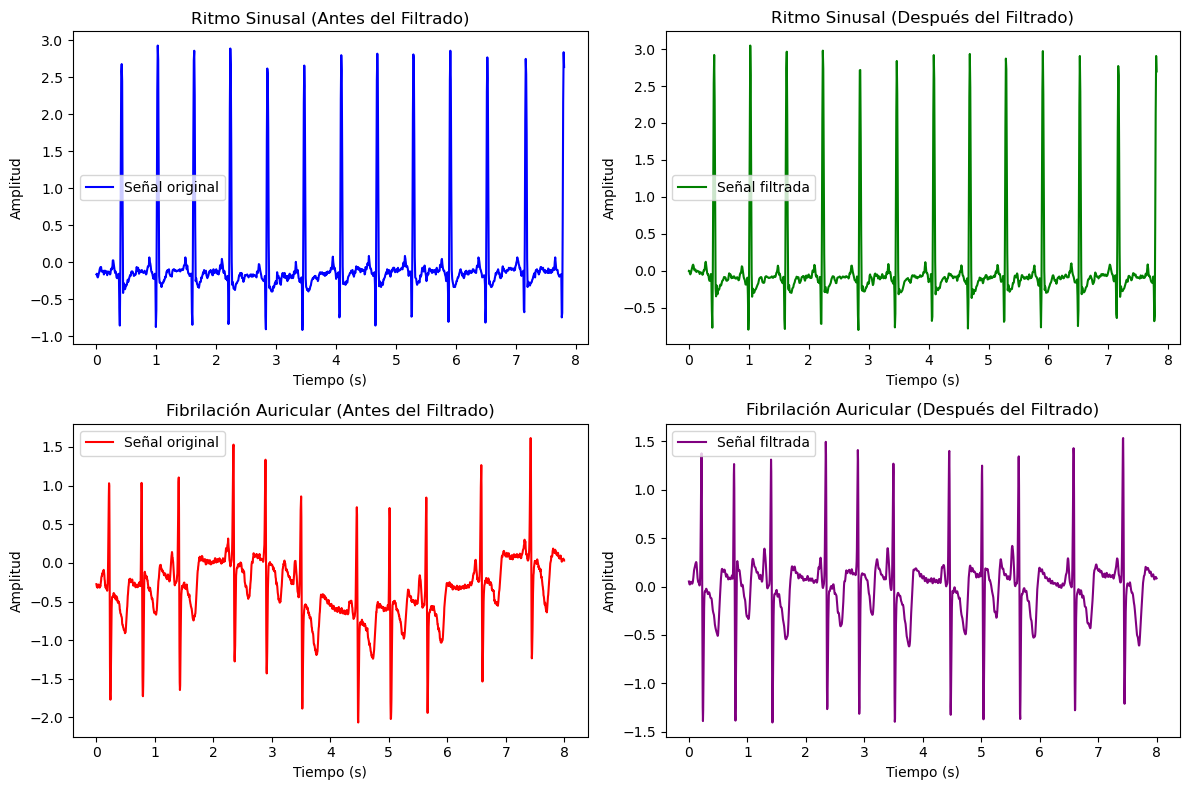

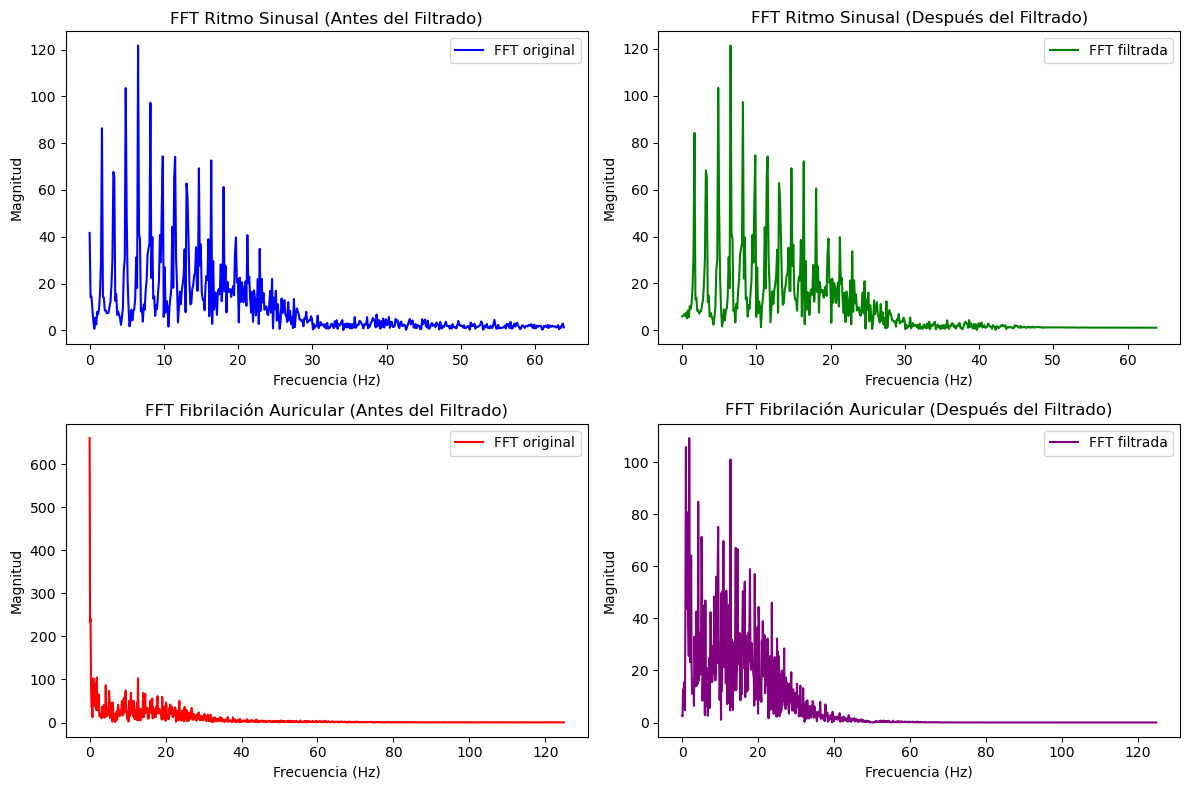

In [64]:
def load_sig(record, database, sampfrom=0, sampto=10000):   # Función para cargar las señales (solo 10000 muestras para mayor rapidez)
    signals, fields = wfdb.rdsamp(record, pn_dir=database, sampfrom=sampfrom, sampto=sampto)
    return signals[:, 0], fields['fs']

signals = []                                                # Cargamos señales
fs_list = []
etiquetas = []
for record in Lista_sinusal:
    senal, fs = load_sig(record, pn_dir_sinusal)
    signals.append(senal)
    fs_list.append(fs)
    etiquetas.append(0)  # 0 => ritmo sinusal (normal)
for record in Lista_fibrilacion:
    senal, fs = load_sig(record, pn_dir_fibrilacion)
    signals.append(senal)
    fs_list.append(fs)
    etiquetas.append(1)  # 1 => fibrilación auricular
    
# PREPROCESADO: Eliminar ruido
def fil_pa(senal, fs):                                      # Filtrado de línea de base / drift (Filtro paso alto) => eliminar movimientos o cambios de impedancias
    b, a = signal.butter(2, 0.5 / (fs / 2), btype='high')
    return signal.filtfilt(b, a, senal)

def fil_notch(senal, fs, f0=50.0, Q=30.0):                  # Filtro notch => eliminar ruido red eléctrica (Europa 50Hz)
    b, a = signal.iirnotch(f0 / (fs / 2), Q)
    return signal.filtfilt(b, a, senal)

def filt_pb(senal, fs, fc=40):                              # Filtro de paso bajo => eliminar ruido muscular (>40 Hz)
    b, a = signal.butter(2, fc / (fs / 2), btype='low')
    return signal.filtfilt(b, a, senal)

signals_filt = []                                           # Guardar señales filtradas
for i, senal in enumerate(signals):
    signal_filt = fil_pa(senal, fs_list[i])
    signal_filt = fil_notch(signal_filt, fs_list[i])
    signal_filt = filt_pb(signal_filt, fs_list[i])
    signals_filt.append(signal_filt)

# Mostrar diferencias entre señales antes y después del filtrado (primer ejemplo)
indice_normal = etiquetas.index(0)  # Primera señal normal
indice_fibrilada = etiquetas.index(1)  # Primera señal fibrilada

senal_normal = signals[indice_normal][:1000]
senal_normal_filt = signals_filt[indice_normal][:1000]      # Seleccionar ECG
fs_normal = fs_list[indice_normal]                          # Seleccionar solo unas pocas muestras para mejor visualización
senal_fibrilada = signals[indice_fibrilada][:2000]
senal_fibrilada_filt = signals_filt[indice_fibrilada][:2000]
fs_fibrilada = fs_list[indice_fibrilada]

t_normal = np.arange(len(senal_normal)) / fs_normal             # Vectores de tiempo
t_fibrilada = np.arange(len(senal_fibrilada)) / fs_fibrilada

def calcular_fft(senal, fs):    # Función para calcular la Transformada de Fourier
    N = len(senal)
    freqs = fftfreq(N, 1/fs)[:N//2]
    fft_values = np.abs(fft(senal)[:N//2])
    return freqs, fft_values
freqs_normal, fft_normal = calcular_fft(senal_normal, fs_normal)
freqs_normal_filt, fft_normal_filt = calcular_fft(senal_normal_filt, fs_normal)     # FFTs de cada señal
freqs_fibrilada, fft_fibrilada = calcular_fft(senal_fibrilada, fs_fibrilada)        
freqs_fibrilada_filt, fft_fibrilada_filt = calcular_fft(senal_fibrilada_filt, fs_fibrilada)

# Dominio del tiempo:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# Señal normal antes del filtrado
axs[0, 0].plot(t_normal, senal_normal, label='Señal original', color='b')
axs[0, 0].set_title("Ritmo Sinusal (Antes del Filtrado)")
axs[0, 0].set_xlabel("Tiempo (s)")
axs[0, 0].set_ylabel("Amplitud")
axs[0, 0].legend()
# Señal normal después del filtrado
axs[0, 1].plot(t_normal, senal_normal_filt, label='Señal filtrada', color='g')
axs[0, 1].set_title("Ritmo Sinusal (Después del Filtrado)")
axs[0, 1].set_xlabel("Tiempo (s)")
axs[0, 1].set_ylabel("Amplitud")
axs[0, 1].legend()
# Señal fibrilada antes del filtrado
axs[1, 0].plot(t_fibrilada, senal_fibrilada, label='Señal original', color='r')
axs[1, 0].set_title("Fibrilación Auricular (Antes del Filtrado)")
axs[1, 0].set_xlabel("Tiempo (s)")
axs[1, 0].set_ylabel("Amplitud")
axs[1, 0].legend()
# Señal fibrilada después del filtrado
axs[1, 1].plot(t_fibrilada, senal_fibrilada_filt, label='Señal filtrada', color='purple')
axs[1, 1].set_title("Fibrilación Auricular (Después del Filtrado)")
axs[1, 1].set_xlabel("Tiempo (s)")
axs[1, 1].set_ylabel("Amplitud")
axs[1, 1].legend()
plt.tight_layout()
plt.show()

# Dominio de la frecuencia:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# FFT señal normal antes del filtrado
axs[0, 0].plot(freqs_normal, fft_normal, label='FFT original', color='b')
axs[0, 0].set_title("FFT Ritmo Sinusal (Antes del Filtrado)")
axs[0, 0].set_xlabel("Frecuencia (Hz)")
axs[0, 0].set_ylabel("Magnitud")
axs[0, 0].legend()
# FFT señal normal después del filtrado
axs[0, 1].plot(freqs_normal_filt, fft_normal_filt, label='FFT filtrada', color='g')
axs[0, 1].set_title("FFT Ritmo Sinusal (Después del Filtrado)")
axs[0, 1].set_xlabel("Frecuencia (Hz)")
axs[0, 1].set_ylabel("Magnitud")
axs[0, 1].legend()
# FFT señal fibrilada antes del filtrado
axs[1, 0].plot(freqs_fibrilada, fft_fibrilada, label='FFT original', color='r')
axs[1, 0].set_title("FFT Fibrilación Auricular (Antes del Filtrado)")
axs[1, 0].set_xlabel("Frecuencia (Hz)")
axs[1, 0].set_ylabel("Magnitud")
axs[1, 0].legend()
# FFT señal fibrilada después del filtrado
axs[1, 1].plot(freqs_fibrilada_filt, fft_fibrilada_filt, label='FFT filtrada', color='purple')
axs[1, 1].set_title("FFT Fibrilación Auricular (Después del Filtrado)")
axs[1, 1].set_xlabel("Frecuencia (Hz)")
axs[1, 1].set_ylabel("Magnitud")
axs[1, 1].legend()
plt.tight_layout()
plt.show()

2. **Extracción de Características**: Identificar y extraer características relevantes de las señales de ECG que permitan diferenciar entre ritmos cardíacos normales y anormales.

In [65]:
def caract_t(senal):                                        # Características del dominio del tiempo
    media = np.mean(senal)  # Promedio (media)
    desviacion = np.std(senal)  # Desviación estándar (típica)
    energia = np.sum(np.abs(senal) ** 2)  # Energía
    entropia = entropy(np.histogram(senal, bins=10)[0] + 1)  # Entropía
    return [media, desviacion, energia, entropia]

def caract_f(senal, fs):                                    # Características del dominio de la frecuencia
    fft_senal = np.abs(fft(senal))  # Transformada de Fourier
    fft_senal = fft_senal[:len(fft_senal)//2]  # Solo mitad positiva
    frec_max = np.argmax(fft_senal)  # Frecuencia con mayor energía
    energia_fft = np.sum(fft_senal ** 2)  # Energía en frecuencia (Parserval)
    return [frec_max, energia_fft]

def HRV(peaks, fs):                                         # Variabilidad de la frecuencia cardíaca (HRV)
    rr_intervals = np.diff(peaks) / fs  # Diferencias de tiempo entre picos R
    return [np.mean(rr_intervals), np.std(rr_intervals)]

X = []                                                      # Extraer características de todas las señales
y = etiquetas  # Etiquetas(0 = normal, 1 = fibrilación)
for i, senal in enumerate(signals_filt):
    fs = fs_list[i]  # Frecuencia de muestreo
    caracteristicas_tiempo = caract_t(senal)
    caracteristicas_frecuencia = caract_f(senal, fs)
    qrs_peaks = wp.gqrs_detect(sig=senal, fs=fs)  # Detectar picos R con algoritmo gqrs
    if len(qrs_peaks) > 1:  # Evitar errores
        caracteristicas_HRV = HRV(qrs_peaks, fs)
    else:
        caracteristicas_HRV = [0, 0]  # Valores por defecto, si no hay picos
    X.append(caracteristicas_tiempo + caracteristicas_frecuencia + caracteristicas_HRV)  # Combinar características
X = np.array(X)  # Convertir a numpy array => Entrenar modelos

3. **Entrenamiento del Modelo**: Utilizar técnicas de aprendizaje automático para entrenar un modelo de clasificación basado en las características extraídas.

In [66]:
# Conjunto de entrenamiento (60%) y Conjunto de prueba (40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
scaler = StandardScaler()                       
X_train = scaler.fit_transform(X_train)                                 # Normalizar las características
X_test = scaler.transform(X_test)

modelo = LogisticRegression()       # Modelo de clasificación => Regresión logística (lineal)
modelo.fit(X_train, y_train)        # Entenar modelo

# Graficamos Regiones de decisión con PCA para reducir a 2 dimensiones (porque X tiene más de dos características)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
modelo_pca = LogisticRegression() # Reentrenar modelo con características reducidas
modelo_pca.fit(X_train_pca, y_train)
xx, yy = np.meshgrid(   # Malla para graficar regiones de decisión
    np.linspace(np.min(X_train_pca[:, 0]), np.max(X_train_pca[:, 0]), 100),
    np.linspace(np.min(X_train_pca[:, 1]), np.max(X_train_pca[:, 1]), 100)
)
data = np.c_[xx.ravel(), yy.ravel()]  # Aplanar malla => predicciones
Z = modelo_pca.predict(data)  # Predecir regiones de decisión
fig = go.Figure()
fig.add_trace(  # Contorno de regiones de decisión
    go.Contour(
        x=np.unique(xx),
        y=np.unique(yy),
        z=Z.reshape(xx.shape),
        colorscale="Turbo",
        showscale=False,
        opacity=0.2,
    )
)
fig.add_trace( # Puntos de datos de prueba
    go.Scatter(
        x=X_test_pca[:, 0],
        y=X_test_pca[:, 1],
        marker=dict(
            size=6,
            color=y_test,  # Colorear según la clase
            colorscale="Turbo",
            cmin=0,
            cmax=1,  # 2 clases: 0 (normal), 1 (fibrilación)
            showscale=True,
        ),
        mode="markers",
    )
)
fig.update_layout(
    title="Regiones de Decisión - Regresión Logística",
    xaxis_title="Componente Principal 1",
    yaxis_title="Componente Principal 2",
)
fig.show()

4. **Evaluación del Modelo**: Evaluar el rendimiento del modelo utilizando métricas adecuadas y ajustar los parámetros según sea necesario.

In [67]:
y_pred = modelo.predict(X_test)     # Predicción => Conjunto de prueba
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))     # Matriz de confusión => Evaluar predicción (aciertos y errores)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))    # Métricas de evaluación => Precisión, Recall y F1-score
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión del Modelo: {accuracy:.4f}")    # Métricas de evaluación => Precisión global (porcentaje en tanto por 1 de aciertos)

Matriz de Confusión:
[[3 2]
 [2 1]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.33      0.33      0.33         3

    accuracy                           0.50         8
   macro avg       0.47      0.47      0.47         8
weighted avg       0.50      0.50      0.50         8


Precisión del Modelo: 0.5000


**OPTIMIZACIÓN DE HIPERPARÁMETROS**:
- Random Forest (no lineal):

In [68]:
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)   # Entrenar nuevo modelo
modelo_rf.fit(X_train, y_train)             # Ajustar datos de entrenamiento
y_pred_rf = modelo_rf.predict(X_test)       # Predicción
print("\nReporte de Clasificación - Random Forest:")
print(classification_report(y_test, y_pred_rf))
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nPrecisión del Modelo: {accuracy_rf:.4f}")

# Graficamos Regiones de decisión con PCA para reducir a 2 dimensiones 
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
mdoelo_rf_pca = RandomForestClassifier(n_estimators=100, random_state=42) # Entrenar Random Forest con datos transformados
mdoelo_rf_pca.fit(X_train_pca, y_train)
xx, yy = np.meshgrid(               # Malla de puntos para graficar regiones de decisión
    np.linspace(np.min(X_train_pca[:, 0]), np.max(X_train_pca[:, 0]), 100),
    np.linspace(np.min(X_train_pca[:, 1]), np.max(X_train_pca[:, 1]), 100)
)
data = np.c_[xx.ravel(), yy.ravel()]  # Aplanar malla de puntos
predictions = mdoelo_rf_pca.predict(data)  # Predecir la clase de cada punto
Z = np.array(predictions).reshape(xx.shape)  # Dar forma a las predicciones
fig = go.Figure()
fig.add_trace(      # Regiones de decisión
    go.Contour(
        x=np.unique(xx),
        y=np.unique(yy),
        z=Z.reshape(xx.shape),
        colorscale="Turbo",
        showscale=False,
        opacity=0.2,
    )
)
fig.add_trace       (# Puntos de prueba
    go.Scatter(
        x=X_test_pca[:, 0],
        y=X_test_pca[:, 1],
        marker=dict(
            size=6,
            color=y_test,  # Color basado en la clase
            colorscale="Turbo",
            cmin=0,
            cmax=1,  # 2 clases: 0 (normal), 1 (fibrilación)
            showscale=True,
        ),
        mode="markers",
    )
)
fig.update_layout(
    title="Regiones de Decisión - Random Forest",
    xaxis_title="Componente Principal 1",
    yaxis_title="Componente Principal 2",
)
fig.show()


Reporte de Clasificación - Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.60      1.00      0.75         3

    accuracy                           0.75         8
   macro avg       0.80      0.80      0.75         8
weighted avg       0.85      0.75      0.75         8


Precisión del Modelo: 0.7500


- Búsqueda en cuadrícula:

In [69]:
parametros = {'C': [0.01, 0.1, 1, 10, 100]}     # Hiperparámetros para Regresión Logística
cv = StratifiedKFold(n_splits=3)  # Validación cruzada estratificada
grid = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), parametros, cv=cv, scoring='accuracy') # Búsqueda de los mejores parámetros
grid.fit(X_train, y_train)              # Ajustar datos de entrenamiento
modelo_grid = grid.best_estimator_      # Mejor Parámetro Encontrado
y_pred_grid = modelo_grid.predict(X_test)   # Predicción
print("\nReporte de Clasificación - Búsqueda en cuadrícula:")
print(classification_report(y_test, y_pred_grid))
accuracy_grid = accuracy_score(y_test, y_pred_grid)
print(f"\nPrecisión del Modelo: {accuracy_grid:.4f}")

# Graficamos Regiones de decisión con PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
modelo_pca = LogisticRegression(C=modelo_grid.C, max_iter=1000) # Reentrenar modelo con características reducidas
modelo_pca.fit(X_train_pca, y_train)
xx, yy = np.meshgrid(  # Malla de puntos para graficar regiones de decisión
    np.linspace(np.min(X_train_pca[:, 0]), np.max(X_train_pca[:, 0]), 100),
    np.linspace(np.min(X_train_pca[:, 1]), np.max(X_train_pca[:, 1]), 100)
)
data = np.c_[xx.ravel(), yy.ravel()]  # Aplanar malla de puntos
Z = modelo_pca.predict(data)  # Predecir clase de cada punto
Z = Z.reshape(xx.shape)  # Dar forma a las predicciones
fig = go.Figure()
fig.add_trace(      # Regiones de decisión
    go.Contour(
        x=np.unique(xx),
        y=np.unique(yy),
        z=Z.reshape(xx.shape),
        colorscale="Turbo",
        showscale=False,
        opacity=0.2,
    )
)
fig.add_trace(      # Puntos de prueba
    go.Scatter(
        x=X_test_pca[:, 0],
        y=X_test_pca[:, 1],
        marker=dict(
            size=6,
            color=y_test,  # Color basado en la clase
            colorscale="Turbo",
            cmin=0,
            cmax=1,  # 2 clases: 0 (normal), 1 (fibrilación)
            showscale=True,
        ),
        mode="markers",
    )
)
fig.update_layout(
    title="Regiones de Decisión - Regresión Logística (con búsqueda en cuadrícula)",
    xaxis_title="Componente Principal 1",
    yaxis_title="Componente Principal 2",
)
fig.show()


Reporte de Clasificación - Búsqueda en cuadrícula:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.50      0.67      0.57         3

    accuracy                           0.62         8
   macro avg       0.62      0.63      0.62         8
weighted avg       0.66      0.62      0.63         8


Precisión del Modelo: 0.6250


5. **Informe Final**: Presentar un informe detallado que incluya la metodología, resultados obtenidos y conclusiones.

A grandes rasgos, este proyecto demuestra que el Machine Learning, prodría ser una gran herramienta a utilizar en el ámbito de la cardiología. Esta conclusión la puedo argumentar gracias a la siguiente metodología:

En primer lugar, utilizamis la base de datos MIT-BIH, donde encontramos distintos conjuntos de datos correspondientes a dos tipos de ECGs, (electrocardiogramas); de ritmo sinusal y de fibrilación auricular. Con on posterior Preprocesado, donde etiquetamos dichos ECGs para su clasificación. En dicho proceso, realizamos 3 tipos de filtrados ordenados de más restrictivo a menos y consecutivos. El primero consiste en un Filtro Paso Alto con doble filtrado, que consigue eliminar en gran medida movimientos detectados y cambios de impedancia, generando la línea de base. en frecuencias altas. El siguiente es el filtro notch, con el cual conseguimos eliminar el ruido provocado por la red eléctrica, teniendo en cuenta que en Europa es de 50 Hz. Y por último, finalizamos el filtrado con un Filtro Paso Bajo para frecuencias < 40 Hz, para principalmente eliminar el ruido muscular. Para verificar los resultados de los filtrados, graficamos dos señales de ejemplo; donde se puede observar que se ha realizado bien dicho filtrado y se tine la información necesaria.

En segundo lugar, extraemos las principales características de las señales, tanto en el dominio de la frecuencia como del tiempo. En el caso del tiempo, calculamos parámetros como la media, varianza, entropía, etc; aportando información que ayuda a describir dichos ECGs. Y en el dominio de la frecuencia, primero hacemos su fft correspondiente, y calculamos la energía media y la frecuencia pico. Por otro lado, también encontré útil hallar distancia entre picod R para hallar sus características HRV, que ayuden a aportar más información al modelo de predicción. Una vez calculados los parámetros, etiquetamos dichos resultados con el tipo de señal al que perteece, pudiendo determinar umbrales que ayuden a decidir entre un tipo y otro de ECG.

Ahora es el turno de crear el modelo a entrenar, donde primero dividimos los parámetros calculados anteriormente en 60% de entrenamiento, (12/20),y el 40% de prueba, (8/20); cuyos valores los normalizo para obtener mejores resultados; también queda destacar que a mayor número de parámetros de entrenamiento, mejor predicción se puede llegar a lograr, eso explica el mayor porcentaje de muestras de entrenamiento. Creo y entreno primeramente un model basado en Regresión Logística, y el cual lo entreno con el 40% de parámetros separados.

Una vez entrenado, evaluo los resultados obtenidos, comparando las predicciones hechas con los parámetros de prueba; concluyendo en que el modelo entrenado obteine una precisión total del 50%. Pruebo a diseñar otro tipo de modelos de predicción para comprobar si se puede conseguir mejor precisión, como el de búsqueda en cuadrícula que utiliza hiperparámetros extras en la regresión logística, obteniendo un porcentaje de precisión del 62,5%. Pero con el modelo de Random Forest, se llegue ha obtener una precisión del 75%, en el cual se generan 100 estimadores extras, pudiendo ser un modelos mucho más preciso y con mayor capacidad de decisión.

## Resultados Esperados

Al finalizar la práctica, habrán adquirido una comprensión profunda del proceso de análisis de señales biomédicas y desarrollado competencias en el uso de herramientas de aprendizaje automático para la clasificación de datos médicos. Además, estarán mejor preparados para enfrentar desafíos en el campo de la ingeniería biomédica y contribuir al desarrollo de soluciones innovadoras para el diagnóstico y tratamiento de enfermedades cardíacas.